## Demo of TopoFlow Solar Radiation Methods

#### Table of Contents

1.  <a href="#intro">Introduction</a> <br>
2.  <a href="#import">Import Required Python Packages</a> <br>
3.  <a href="#julian_day">Julian Day of the Year (Decimal)</a> <br>
4.  <a href="#functions">Julian Days of Solstices and Equinoxes</a> <br>
5.  <a href="#check_dec">Solar Declination on Solstices and Equinoxes</a> <br>
6.  <a href="#declination">Solar Declination vs. Julian Day</a> <br>
7.  <a href="#elev_angle">Solar Elevation Angle vs. Julian Day at Solar Noon for Several Latitudes</a> <br>
8.  <a href="#eccentricity">Earth Orbit Eccentricity Correction vs. Julian Day</a> <br>
9.  <a href="#zenith_angle">Solar Zenith Angle vs. Hour Offset from Solar Noon</a> <br>
10. <a href="#ET_rad_flux">ET Radiation Flux vs. Hour Offset from Solar Noon</a> <br>
11. <a href="#clearsky_rad_flux">Clear-Sky Radiation Flux vs. Hour Offset from Solar Noon</a> <br>
12. <a href="#sunrise">Sunrise and Sunset Times, Accounting for Slope and Aspect</a> <br>
13. <a href="#day_length_eq">Day Length vs. Julian Day at Different Latitudes</a>
14. <a href="#day_length_lat">Day Length vs. Latitude on Solstices</a>
15. <a href="#day_length_slope">Day Length vs. Slope for Two Latitudes When Aspect=0</a> <br>
16. <a href="#day_length_aspect">Day Length vs. Aspect For Two Latitudes When Slope > 0</a> <br>
17. <a href="#setup">Appendix 1:  Installing TopoFlow in a conda Environment</a>

### Introduction  <a id="intro"></a>

TopoFlow contains a module in the components folder called <b>solar_funcs.py</b> that contains functions to simulate the <b>celestial mechanics</b> of the Earth-Sun system for the purpose of calculating the amount of <b>solar radiation</b> (shortwave) that reaches the earth at different locations on earth, at different times of year, while also taking topographic slope and aspect into account.  This notebook shows many of the capabilities of the the solar_funcs module.  These are used by the  [<b>TopoFlow Meteorology component</b>](https://csdms.colorado.edu/wiki/Model_help:TopoFlow-Meteorology), which also calculates longwave radiation.  (However, they are only used when the PRECIP_ONLY flag in the CFG file for the Meteorology component is set to "No".)  The Meteorology component provides inputs needed by the [<b>Snowmelt Energy Balance</b>](https://csdms.colorado.edu/wiki/Model:TopoFlow-Snowmelt-Energy_Balance) component and the [<b>Evaporation Energy Balance</b>](https://csdms.colorado.edu/wiki/Model:TopoFlow-Evaporation-Energy_Balance) component.  The functions in the solar_funcs module are mostly based on those in Dingman's book, Physical Hydrology, 2nd edition, Appendix E.  Each function accepts its arguments as either scalars or arrays (e.g. 2D grids).  

Before you can run the code in this notebook, you will need to install the TopoFlow 3.6 Python package.  Detailed instructions and background information for how to install TopoFlow in a conda environment are given in
<a href="#setup"><b>Appendix 1:  Installing TopoFlow in a conda Environment</b></a>.


### Import Required Python Packages  <a id="import"></a>

In [1]:
import numpy as np
from topoflow.components import solar_funcs as solar
from topoflow.utils import visualize as tfvis

Importing TopoFlow 3.6 package modules:
   topoflow.utils
   topoflow.utils.tests
   topoflow.components
   topoflow.components.tests
   topoflow.framework
   topoflow.framework.tests
 


### Julian Day of the Year (Decimal) <a id="julian_day"></a>
The arguments of the Julian_Day() function are month number, day number, hour number (UTC), and year.  As implemented here, regular years have exactly 365.0 days, while leap years have 366.0 days. Also, as implemented here, JD < 1 between midnight of 12-31 (start of the day 01-01) to midnight of 01-01 (start of the day 01-02).  That is, we have JD=1 when one, full 24-hour day has elapsed in the given year, and JD=365 when a full 24-day has elapsed on the last day of the year (or 366 for leap years).

In [2]:
print( solar.Julian_Day(1,1,0) )
print( solar.Julian_Day(1,1,24) )
print( solar.Julian_Day(2,1,0) )
print( solar.Julian_Day(3,1,0) )
print( solar.Julian_Day(3,1,24) )
print( solar.Julian_Day(3,1,24, year=2024))
print( solar.Julian_Day(4,5,0) )
print( solar.Julian_Day(12,31,0, year=2023) )
print( solar.Julian_Day(12,31,24, year=2023) )
print( solar.Julian_Day(12,31,24, year=2024) )

0.0
1.0
31.0
59.0
60.0
61.0
94.0
364.0
365.0
366.0


### Julian Days of Solstices and Equinoxes  <a id="functions"></a>
During a <b>solar equinox</b>, the Earth's rotation axis is exactly perpendicular to the line between the centers of the Sun and the Earth.  Recall that Earth's rotation axis is always tilted 23.44 degrees away from a perpendicular to it orbital plane (the ecliptic).  (A value of 23.5 degrees is often cited, but 23.44 is currently the more correct value.)  This celestial event occurs twice a year, close to March 20th and September 23rd, but does not occur on the same day every year.  On the day of an equinox, at the equator, the Sun will appear to be directly overhead at local noon.  Also on these 2 days, for every latitude, the day length and night length are both equal to 12 hours.  The word "equinox" is Latin for "equal night".

During a <b>solar solstice</b>, the angle between Earth's rotation axis and the Earth-Sun line reaches one of its two most extreme values.  When this event occurs in June --- the "June solstice" or "northern hemisphere summer solstice" or "southern hemisphere winter solstice" --- the angle between the northern half of Earth's rotation axis and the Earth-Sun line is equal to 90 - 23.44 = 66.56 and the day length in the northern hemisphere reaches its maximum value, while the day length in the southern hemisphere reaches its minimum value.  When this event occurs in December --- the "December solstice" or "northern hemisphere winter solstice" or "southern hemisphere summer solstice" --- the angle between the southern half of Earth's rotation axis and the Earth-Sun line is equal to 90 - 23.44 = 66.56 and the day length in the northern hemisphere reaches its minimum value, while the day length in the southern hemisphere reaches its maximum value.
This celestial event also occurs twice a year, close to June 21st and December 21st, but does not occur on the same day every year.  On the June solstice, the sun will attain its maximum <b>elevation angle</b> for any given latitude in the northern hemisphere and it's minimum value for any given latitude in the southern hemisphere.  The opposite occurs on the December solstice.

In [3]:
# See Wikipedia: March Equinox
#--------------------------------
def Earth_Tilt_Angle():
    return 23.44
#------------------------------------------------------------------------
def December_Solstice_Julian_Day_2023( hour_num=3.5 ):
    JD = solar.Julian_Day(12, 22, hour_num=hour_num, year=2023)
    return JD
#------------------------------------------------------------------------
def June_Solstice_Julian_Day_2023( hour_num=15.0 ):
    JD = solar.Julian_Day(6, 21, hour_num=hour_num, year=2023)
    return JD
#------------------------------------------------------------------------
def March_Equinox_Julian_Day_2023( hour_num=21.5 ):
    JD = solar.Julian_Day(3, 20, hour_num=hour_num, year=2023)
    return JD
#------------------------------------------------------------------------
def September_Equinox_Julian_Day_2023( hour_num=6.8333 ):
    JD = solar.Julian_Day(9, 23, hour_num=hour_num, year=2023)
    return JD
#------------------------------------------------------------------------
def Arctic_Circle_Latitude():
    return 66.56   # (90 - 23.44)
#------------------------------------------------------------------------
def Antarctic_Circle_Latitude():
    return -66.56
#------------------------------------------------------------------------
def Tropic_of_Cancer_Latitude():
    # Most northerly latitude that has a zenith angle of 0
    #   at solar noon on the June solstice.
    #   Also called the "Northern Tropic"
    return 23.44  
#------------------------------------------------------------------------
def Tropic_of_Capricorn_Latitude():
    # Most southerly latitude that has a zenith angle of 0
    #   at solar noon on the December solstice.
    #   Also called the "Southern Tropic"
    return -23.44


### Solar Declination on Solstices and Equinoxes  <a id="check_dec"></a>

In [4]:
JD = December_Solstice_Julian_Day_2023()  # declination close to -23.44 deg
# JD = June_Solstice_Julian_Day_2023()      # declination close to +23.44 deg
# JD = March_Equinox_Julian_Day_2023()      # declination close to 0.0 deg
# JD = September_Equinox_Julian_Day_2023()    # declination close to 0.0 deg

DA = solar.Day_Angle( JD)
D  = solar.Declination( DA )
print('Julian Day  =', JD)
print('Day Angle   =', DA, ' [radians]')
print('Day Angle   =', DA * (180/3.14159), ' [degrees]')
print('Declination =', D, ' [radians]')
print('Declination =', D * (180/3.14159), ' [degrees]')

Julian Day  = 355.1458333333333
Day Angle   = 6.113553649057672  [radians]
Day Angle   = 350.28111778761104  [degrees]
Declination = -0.408865765117057  [radians]
Declination = -23.42630251594583  [degrees]


### Solar Declination vs. Julian Day  <a id="declination"></a>

ymin1, ymax1 = -23.426039035075107 23.4555686938443


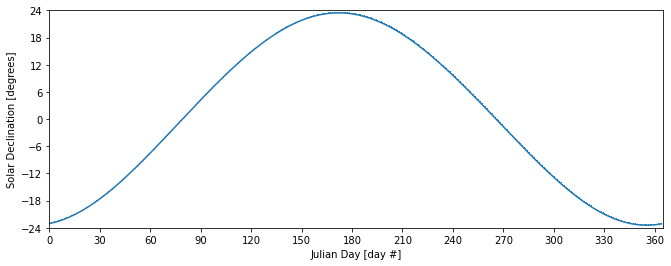

In [5]:
x  = np.arange(365)
x2 = solar.Day_Angle( x)
xticks = 30 * np.arange(13)

y  = solar.Declination( x2 ) * (180.0 / np.pi)
yticks = 6 * (np.arange(9) - 4)
ymin1 = y.min()
ymax1 = y.max()
print('ymin1, ymax1 =', ymin1, ymax1)

tfvis.plot_data( x, y, xmin=0.0, xmax=365.0, ymin=-24.0, ymax=24.0,
                 x_name='Julian Day', x_units='day #',
                 y_name='Solar Declination', y_units='degrees',
                 x_size=11, y_size=4, xticks=xticks, yticks=yticks)

### Solar Elevation Angle vs. Julian Day at Solar Noon for Several Latitudes  <a id="elev_angle"></a>
The <b>solar elevation angle</b> can be 90 degrees at <b>solar noon</b> --- meaning that the sun is directly overhead --- for any latitude between the <b>Tropic of Capricorn</b> (-23.44 degrees lat.) and the <b>Tropic of Cancer</b> (+23.44 degrees lat.).  These latitudes result from the fact that the Earth's rotational axis is tilted by 23.44 degrees from its orbital plane.
(Recall that the <b>solar zenith angle</b> is the complement of the solar elevation angle and is therefore zero at these times.)
However, for latitudes outside of this range, the maximum value of the solar elevation angle is less than 90 degrees, and this maximum value decreases as the absolute value of the latitude increases. 
At the latitude of the <b>Artic Circle</b> (66.56 degrees lat.), on the day of the December solstice, the sun doesn't rise above the horizon at all, and the solar elevation angle on that day at solar noon is zero.  Above the Arctic Circle, the number of consecutive days when the sun doesn't rise at all increases.  At the <b>North Pole</b> (90 degrees lat.), the sun doesn't rise for 6 months, between the September equinox and the March equinox. On the June solstice, however, it attains a maximum elevation angle of 23.44 degrees.

Notice that at the Equator, the two days when the sun is directly overhead at solar noon are the March and September equinoxes.  However, for other latitudes strictly between the Tropics of Cancer and Capricorn, the two days that the sun is directly overhead occur on days that are between the two equinoxes.  As latitude increases from 0 at the equator, these two days get closer and closer to each other until they converge to the day of the June solstice when the Tropic of Cancer or Capricorn is reached.

All of these facts can be seen in the plot below.  You can make a similar plot for the southern hemisphere by simply changing the sign of the latitudes in the definitions of y2 through y8.

y1_min, y1_max = 66.5444313061557 , 89.93407596299161
y2_min, y2_max = 57.573960964924886 , 89.93055449957905
y3_min, y3_max = 48.57396096492488 , 89.97265492633558
y4_min, y4_max = 43.173960964924895 , 89.99998482298768
y5_min, y5_max = 36.57396096492489 , 83.45556869384436
y6_min, y6_max = 21.5739609649249 , 68.45556869384431
y7_min, y7_max = -0.026039035075103516 , 46.85556869384431
y8_min, y8_max = -23.326039035075116 , 23.555568693844293

Tropic of Cancer Latitude = 23.44
March Equinox:     JD = 78.89583333333333
June Solstice:     JD = 171.625
September Equinox: JD = 265.2847208333333
December Solstice: JD = 355.1458333333333


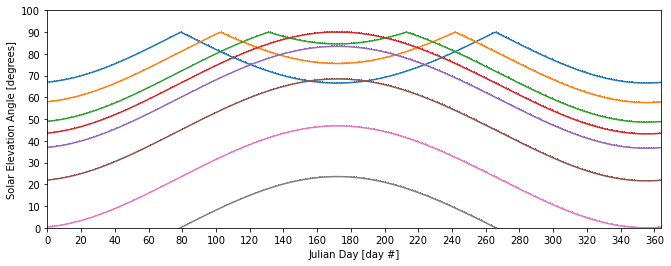

In [46]:
hour_offset = 0.0  # solar noon

x  = np.arange(365)  # Julian days
x2 = solar.Day_Angle( x )
declination = solar.Declination( x2 )  # radians
# xticks = 30 * np.arange(13)
xticks = 20 * np.arange(19)
y1=None; y2=None; y3=None; y4=None;
y5=None; y6=None; y7=None; y8=None;

y1 = solar.Solar_Elevation_Angle(0.0, declination, hour_offset, DEGREES=True )
y2 = solar.Solar_Elevation_Angle(9.0, declination, hour_offset, DEGREES=True )
y3 = solar.Solar_Elevation_Angle(18.0,declination, hour_offset, DEGREES=True )
# Next one is the Tropic of Cancer
y4 = solar.Solar_Elevation_Angle(23.4,declination, hour_offset, DEGREES=True )
y5 = solar.Solar_Elevation_Angle(30.0,declination, hour_offset, DEGREES=True )
y6 = solar.Solar_Elevation_Angle(45.0,declination, hour_offset, DEGREES=True )
# Next one is the Arctic Circle
y7 = solar.Solar_Elevation_Angle(66.6,declination, hour_offset, DEGREES=True )
y8 = solar.Solar_Elevation_Angle(89.9,declination, hour_offset, DEGREES=True )

yticks = 10 * (np.arange(11))
print('y1_min, y1_max =', y1.min(), ',', y1.max())
if (y2 is not None):
    print('y2_min, y2_max =', y2.min(), ',', y2.max())
if (y3 is not None):
    print('y3_min, y3_max =', y3.min(), ',', y3.max())
if (y4 is not None):
    print('y4_min, y4_max =', y4.min(), ',', y4.max())
if (y5 is not None):
    print('y5_min, y5_max =', y5.min(), ',', y5.max())
if (y6 is not None):
    print('y6_min, y6_max =', y6.min(), ',', y6.max())
if (y7 is not None):
    print('y7_min, y7_max =', y7.min(), ',', y7.max())
if (y8 is not None):
    print('y8_min, y8_max =', y8.min(), ',', y8.max())
    
JD1 = March_Equinox_Julian_Day_2023()
JD2 = June_Solstice_Julian_Day_2023()
JD3 = September_Equinox_Julian_Day_2023()
JD4 = December_Solstice_Julian_Day_2023()
print()
print('Tropic of Cancer Latitude =', 23.44)
print('March Equinox:     JD =', JD1)
print('June Solstice:     JD =', JD2)
print('September Equinox: JD =', JD3)
print('December Solstice: JD =', JD4)

tfvis.plot_data( x, y1, y2=y2, y3=y3, y4=y4, y5=y5,
                 y6=y6, y7=y7, y8=y8, 
                 xmin=x.min(), xmax=x.max(),
                 ymin=0, ymax=90.0,
                 x_name='Julian Day', x_units='day #',
                 y_name='Solar Elevation Angle', y_units='degrees',
                 x_size=11, y_size=4, xticks=xticks, yticks=yticks)

### Earth Orbit Eccentricity Correction vs. Julian Day  <a id="eccentricity"></a>

ymin1, ymax1 = 0.9665885739261216 1.0350773742999697


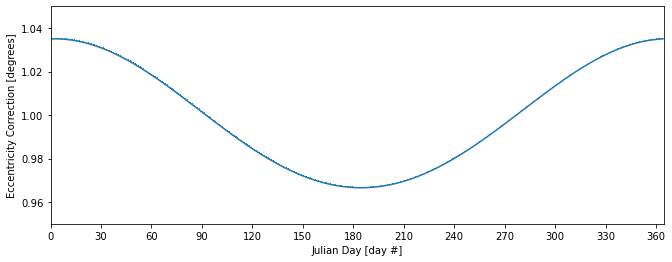

In [6]:
x  = np.arange(365)
x2 = solar.Day_Angle( x)
xticks = 30 * np.arange(13)

y  = solar.Eccentricity_Correction( x2 )  ## * (180.0 / np.pi)
ymin1 = y.min()
ymax1 = y.max()
print('ymin1, ymax1 =', ymin1, ymax1)

tfvis.plot_data( x, y, xmin=0.0, xmax=365.0, ymin=0.95, ymax=1.05,
                 x_name='Julian Day', x_units='day #',
                 y_name='Eccentricity Correction', y_units='degrees',
                 x_size=11, y_size=4, xticks=xticks)

### Solar Zenith Angle vs. Hour Offset from Solar Noon  <a id="zenith_angle"></a>
The solar zenith angle is the complement of the solar elevation angle.  It is the angle that a vector pointing to the sun from a location on Earth makes with the zenith (straight up).  It is 90 degrees at sunrise and sunset and 0.0 at true solar noon.  It is greater than 90 degrees at night, between sunset and sunrise.

Julian Day = 78.66666666666667
ymin1, ymax1 = 9.419797270302443e-05 179.80239587218423


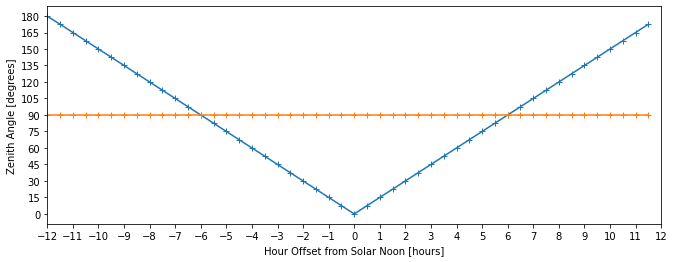

In [7]:
lat_deg = 0.0    # Equator
# lat_deg = 40.0   # Boulder

th = 0.5*np.arange(48) - 12.0  # (hour offsets from solar noon)
x = th
xticks = np.arange(25) - 12.0

JD = March_Equinox_Julian_Day_2023(hour_num=16)
# JD = September_Equinox_Julian_Day_2023(hour_num=3.43)
print("Julian Day =", JD)
Julian_day   = JD + np.arange(48)/48.0
day_angle    = solar.Day_Angle( Julian_day )
declination  = solar.Declination( day_angle, DEGREES=False )
zenith_angle = solar.Zenith_Angle(lat_deg, declination, th)  # req. declination in radians
zenith_angle_deg = zenith_angle * (180/np.pi)
y  = zenith_angle_deg
y2 = 90.0 + np.zeros(48)
yticks = 15.0 * np.arange(13)
ymin1 = y.min()
ymax1 = y.max()
print('ymin1, ymax1 =', ymin1, ymax1)

tfvis.plot_data( x, y, y2=y2, xmin=-12, xmax=12,
                 x_name='Hour Offset from Solar Noon', x_units='hours',
                 y_name='Zenith Angle', y_units='degrees',
                 marker='+', x_size=11, y_size=4, xticks=xticks, yticks=yticks)


### Extra-Terrestrial Radiation Flux vs. Hour Offset from Solar Noon <a id="ET_rad_flux"></a>

ymin1, ymax1 = 0.0 1120.1551046382112
Sunrise = -6.379549992867728 hours before solar noon.
Sunset  = 6.379549992867728 hours after solar noon.
Day length = 12.759099985735457 hours.


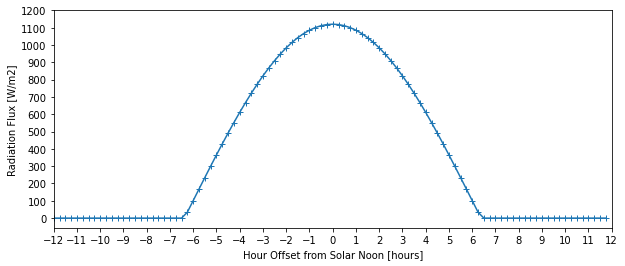

In [8]:
# lat_deg = 0.0    # Equator
lat_deg = 40.0   # Boulder

# JD = 180.0
JD = solar.Julian_Day(9, 6, year=2023)

# Hour offsets to nearest half hour
#th = 0.5*np.arange(48) - 12.0  # (hour offsets from solar noon)
# Hour offsets to nearest 15 minutes
th = 0.25*np.arange(96) - 12.0  # (hour offsets from solar noon)
x = th
xticks = np.arange(25) - 12.0

# This does not take slope & aspect into account.
# Use solar.ET_Radiation_Flux_Slope() for that.
y = solar.ET_Radiation_Flux( lat_deg, JD, th )

ymin1 = y.min()
ymax1 = y.max()
print('ymin1, ymax1 =', ymin1, ymax1)
yticks = 100.0 * np.arange(13)

day_angle   = solar.Day_Angle( JD )
declination = solar.Declination( day_angle, DEGREES=False )
sr_off      = solar.Sunrise_Offset( lat_deg, declination )
ss_off      = solar.Sunset_Offset( lat_deg, declination )
day_length  = solar.Day_Length( lat_deg, JD )
print('Sunrise =', sr_off, 'hours before solar noon.' )
print('Sunset  =', ss_off, 'hours after solar noon.' )
print('Day length =', day_length, 'hours.')
#------------------------------------------------------------
# x2 = x[ y > 0]
# sr_off = x2.min()  # approximate
# ss_off = x2.max()
# print('Day length =', ss_off-sr_off, 'hours (approx)')

tfvis.plot_data( x, y, xmin=-12, xmax=12,
                 ## ymin=0.95, ymax=1.05,
                 x_name='Hour Offset from Solar Noon', x_units='hours',
                 y_name='Radiation Flux', y_units='W/m2',
                 marker='+', x_size=10, y_size=4,
                 xticks=xticks, yticks=yticks)


### Clear-Sky Radiation Flux vs. Hour Offset from Solar Noon <a id="clearsky_rad_flux"></a>

Clear-sky radiation flux is computed by first including the effect of atmospheric
transmissivity to reduce the ET_Radiation_Flux and then adding the <b>diffuse radiation flux</b> and the <b>backscattered radiation flux</b>. <br>
If tau = atmospheric transmissivity, then:<br>
&nbsp; &nbsp; &nbsp; Q_clearsky  = (tau * Q_ET) + Q_diffuse + Q_backscattered.

y1_min, y1_max = 0.0 , 951.3963437599348
Sunrise = -6.379549992867728 hours before solar noon.
Sunset  = 6.379549992867728 hours after solar noon.
Day length = 12.759099985735457 hours.


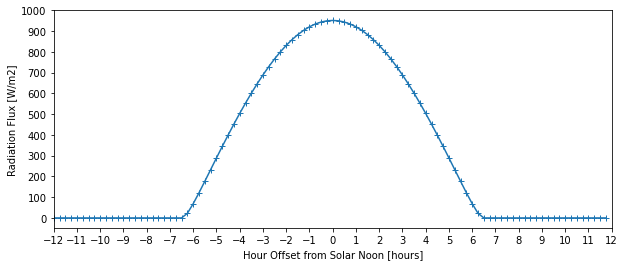

In [9]:
# lat_deg = 0.0    # Equator
lat_deg = 40.0   # Boulder

# JD = 180.0
JD = solar.Julian_Day(9, 6, year=2023)

# Hour offsets to nearest half hour
#th = 0.5*np.arange(48) - 12.0  # (hour offsets from solar noon)
# Hour offsets to nearest 15 minutes
th = 0.25*np.arange(96) - 12.0  # (hour offsets from solar noon)
x = th
xticks = np.arange(25) - 12.0
 
# alpha = "aspect_angle" or azimuthm measured CW from north [radians]
# beta  = "slope angle" [radians], satisfies slope = tan(beta)
# gamma_dust = dust attenuation factor
T_air  = 25.0  # [deg_C]
RH     = 0.3   # relative humidity, unitless
W_p    = solar.Precipitable_Water_Content(T_air, RH)
alpha  = 0.0
beta   = 0.0
albedo = 0.8
gdust  = solar.Dust_Attenuation()
y1 = solar.Clear_Sky_Radiation( lat_deg, JD, W_p, th,
                               alpha, beta, albedo, gdust )

print('y1_min, y1_max =', y1.min(), ',', y1.max() )
yticks = 100.0 * np.arange(11)

day_angle   = solar.Day_Angle( JD )
declination = solar.Declination( day_angle, DEGREES=False )
sr_off      = solar.Sunrise_Offset( lat_deg, declination )
ss_off      = solar.Sunset_Offset( lat_deg, declination )
day_length  = solar.Day_Length( lat_deg, JD )
print('Sunrise =', sr_off, 'hours before solar noon.' )
print('Sunset  =', ss_off, 'hours after solar noon.' )
print('Day length =', day_length, 'hours.')
#------------------------------------------------------------
# x2 = x[ y > 0]
# sr_off = x2.min()  # approximate
# ss_off = x2.max()
# print('Day length =', ss_off-sr_off, 'hours (approx)')

tfvis.plot_data( x, y1, xmin=-12, xmax=12,
                 ## ymin=0.95, ymax=1.05,
                 x_name='Hour Offset from Solar Noon', x_units='hours',
                 y_name='Radiation Flux', y_units='W/m2',
                 marker='+', x_size=10, y_size=4,
                 xticks=xticks, yticks=yticks)


### Sunrise and Sunset Times, Accounting for Slope & Aspect  <a id="sunrise"></a>

In [10]:
#---------------------------------------------------------------
# Notes:  beta  = "slope angle" satisfies slope = tan(beta).
#         alpha = "aspect_angle" or azimuth is measured
#                 clockwise from north.
#         Both angles have units of radians.
#---------------------------------------------------------------
# lat_deg = 0.0  # (Equator)
lat_deg = 40.0
Julian_day = 1.0
beta  = 20.0 * (np.pi / 180.0)
# beta  = 40.0 * (np.pi / 180.0)  # makes day length = zero !
#---------------------------------------------------------------
alpha_N = 0.0  # north facing slope
sunrise_offset_N = solar.Sunrise_Offset_Slope(lat_deg, Julian_day, alpha_N, beta)
sunset_offset_N  = solar.Sunset_Offset_Slope(lat_deg, Julian_day, alpha_N, beta)
day_length_N     = solar.Day_Length_Slope( lat_deg, Julian_day, alpha_N, beta )

# These are grids if alpha and beta are grids.
print('Sunrise offset, north facing =', sunrise_offset_N, 'hours' )
print('Sunset offset, north facing  =', sunset_offset_N, 'hours' )
print('Day length, north facing =', day_length_N, 'hours' )
print()
#---------------------------------------------------------------
alpha_S = np.pi  # south facing slope
sunrise_offset_S = solar.Sunrise_Offset_Slope(lat_deg, Julian_day, alpha_S, beta)
sunset_offset_S  = solar.Sunset_Offset_Slope(lat_deg, Julian_day, alpha_S, beta)
day_length_S     = solar.Day_Length_Slope( lat_deg, Julian_day, alpha_S, beta )

# These are grids if alpha and beta are grids.
print('Sunrise offset, south facing =', sunrise_offset_S, 'hours' )
print('Sunset offset, south facing  =', sunset_offset_S, 'hours' )
print('Day length, south facing =', day_length_S, 'hours' )
print()


Sunrise offset, north facing = -2.8491415938138247 hours
Sunset offset, north facing  = 2.8491415938138247 hours
Day length, north facing = 5.698283187627649 hours

Sunrise offset, south facing = -4.610420803544746 hours
Sunset offset, south facing  = 4.610420803544746 hours
Day length, south facing = 9.220841607089492 hours



ymin1, ymax1 = -23.426039035075107 23.4555686938443


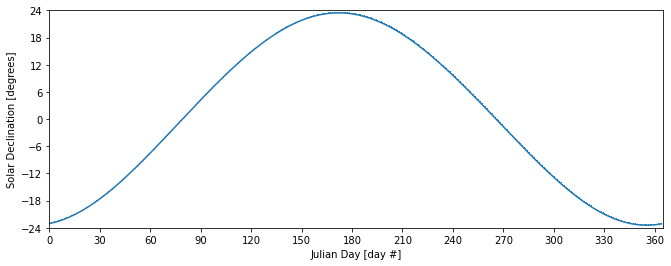

In [5]:
x  = np.arange(365)
x2 = solar.Day_Angle( x)
xticks = 30 * np.arange(13)

y  = solar.Declination( x2 ) * (180.0 / np.pi)
yticks = 6 * (np.arange(9) - 4)
ymin1 = y.min()
ymax1 = y.max()
print('ymin1, ymax1 =', ymin1, ymax1)

tfvis.plot_data( x, y, xmin=0.0, xmax=365.0, ymin=-24.0, ymax=24.0,
                 x_name='Julian Day', x_units='day #',
                 y_name='Solar Declination', y_units='degrees',
                 x_size=11, y_size=4, xticks=xticks, yticks=yticks)

ymin1, ymax1 = -23.426039035075107 23.4555686938443


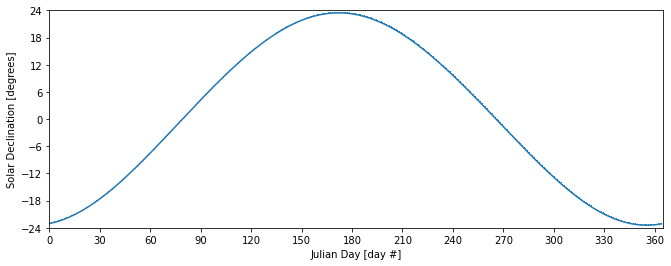

In [5]:
x  = np.arange(365)
x2 = solar.Day_Angle( x)
xticks = 30 * np.arange(13)

y  = solar.Declination( x2 ) * (180.0 / np.pi)
yticks = 6 * (np.arange(9) - 4)
ymin1 = y.min()
ymax1 = y.max()
print('ymin1, ymax1 =', ymin1, ymax1)

tfvis.plot_data( x, y, xmin=0.0, xmax=365.0, ymin=-24.0, ymax=24.0,
                 x_name='Julian Day', x_units='day #',
                 y_name='Solar Declination', y_units='degrees',
                 x_size=11, y_size=4, xticks=xticks, yticks=yticks)

### Day Length vs. Julian Day at Different Latitudes  <a id="day_length_eq"></a>
At the equator, the day length (and night length) is 12 hours, for every day of the year.
For all latitudes, day length is longest on the June Solstice and shortest on the December Solstice.  The length of the longest day is 12 hours at the equator and increases with latitude, up to 24 hours between the Arctic Circle and the North Pole. 
For latitudes between 0 (Equator) and 66.56 (Arctic Circle) day length varies with a smooth, almost sinusoidal curve.  At the Arctic Circle, the June solstice day has 24 hours of sunlight, but for just that one day.  Further north, there will be 24-hour sunlight in summer (or 24-hour darkness in winter) for many consecutive days or months, reaching 6 months at the North Pole.

Notice that on the dates of the March equinox (day 78.9) and September equinox (day 265.3), day length (and night length) is 12 hours for all latitudes.  The word equinox comes from the Latin for "equal night".

March Equinox Julian Day     = 78.89583333333333
June Solstice Julian Day     = 171.625
September Equinox Julian Day = 265.2847208333333
December Solstice Julian Day = 355.1458333333333


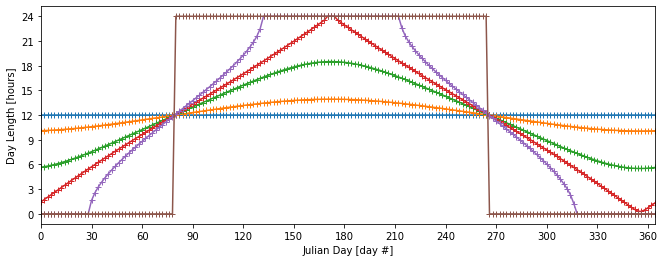

In [43]:
Julian_days = 2 * np.arange(183)
lat_deg   = 0.0  # at the equator
alpha_rad = 0.0
beta_rad  = 0.0

x = Julian_days
xticks = 30 * np.arange(13)
y1 = solar.Day_Length_Slope( lat_deg, Julian_days, alpha_rad, beta_rad )
y2 = solar.Day_Length_Slope( 30.0, Julian_days, alpha_rad, beta_rad )
y3 = solar.Day_Length_Slope( 60.0, Julian_days, alpha_rad, beta_rad )
y4 = solar.Day_Length_Slope( 66.56, Julian_days, alpha_rad, beta_rad )
y5 = solar.Day_Length_Slope( 72.0, Julian_days, alpha_rad, beta_rad )
y6 = solar.Day_Length_Slope( 89.9, Julian_days, alpha_rad, beta_rad )
yticks = 3*np.arange(9)

JD1 = March_Equinox_Julian_Day_2023()
JD2 = June_Solstice_Julian_Day_2023()
JD3 = September_Equinox_Julian_Day_2023()
JD4 = December_Solstice_Julian_Day_2023()
print('March Equinox Julian Day     =', JD1)
print('June Solstice Julian Day     =', JD2)
print('September Equinox Julian Day =', JD3)
print('December Solstice Julian Day =', JD4)

tfvis.plot_data( x, y1, y2=y2, y3=y3, y4=y4, y5=y5, y6=y6,
                 xmin=x.min(), xmax=x.max(),
                 x_name='Julian Day', x_units='day #',
                 y_name='Day Length', y_units='hours',
                 marker='+', x_size=11, y_size=4,
                 xticks=xticks, yticks=yticks)

### Day Length vs. Latitude on Solstices  <a id="day_length_lat"></a>

y1_min, y1_max = 0.0 , 12.0
y2_min, y2_max = 12.0 , 24.0
Day length1 above Arctic Circle on December solstice = 0.0 hours
Day length2 above Arctic Circle on June solstice = 24.0 hours
Day length3 at Equator = 12.0 hours


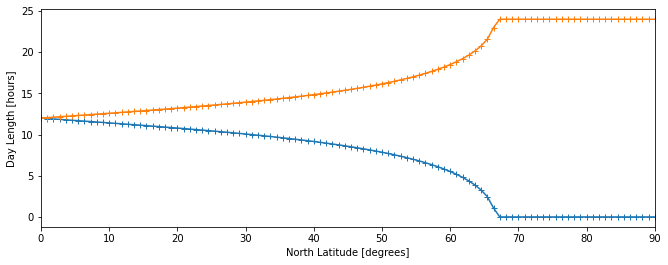

In [36]:
Julian_day1 = December_Solstice_Julian_Day_2023()
Julian_day2 = June_Solstice_Julian_Day_2023()
alpha_rad   = 0.0  # North-facing slope
beta_rad    = 0.0  # flat
lat_deg    = (np.arange(100))/99 * 90.0

x  = lat_deg
y1 = solar.Day_Length_Slope( lat_deg, Julian_day1, alpha_rad, beta_rad )
y2 = solar.Day_Length_Slope( lat_deg, Julian_day2, alpha_rad, beta_rad )
yticks = 1.0 * np.arange(13)

print('y1_min, y1_max =', y1.min(), ',', y1.max())
print('y2_min, y2_max =', y2.min(), ',', y2.max())

ac_lat_deg = Arctic_Circle_Latitude()
ac_lat_deg = 66.6

dl1 = solar.Day_Length_Slope( ac_lat_deg, Julian_day1, alpha_rad, beta_rad )
print('Day length1 above Arctic Circle on December solstice =', dl1, 'hours')
dl2 = solar.Day_Length_Slope( ac_lat_deg, Julian_day2, alpha_rad, beta_rad )
print('Day length2 above Arctic Circle on June solstice =', dl2, 'hours')
dl3 = solar.Day_Length_Slope( 0.0, Julian_day1, alpha_rad, beta_rad )
print('Day length3 at Equator =', dl3, 'hours')

tfvis.plot_data( x, y1, y2=y2, xmin=x.min(), xmax=x.max(),
                 x_name='North Latitude', x_units='degrees',
                 y_name='Day Length', y_units='hours',
                 marker='+', x_size=11, y_size=4)

### Day Length vs. Slope for Two Latitudes When Aspect=0  <a id="day_length_slope"></a>

Day length is shorter for a north-facing slope (than for a south-facing slope), and also gets shorter with increasing north latitude.  For a north-facing slope that is steep enough, the day length can become zero.  However, on the June solstice, the day length is independent of the slope angle for latitudes between the Antarctic and Arctic circles!

y1_min, y1_max = 0.0 , 9.157403141196198
y2_min, y2_max = 0.0 , 10.7901931073883


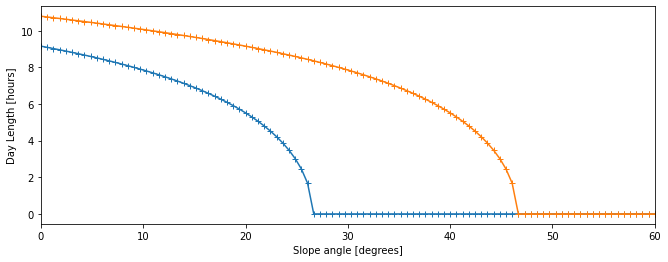

In [12]:
# lat_deg1 = 80.0
# lat_deg1 = 67.0  # Just above Arctic Circle
lat_deg1 = 40.0    # Boulder, Colorado
lat_deg2 = 20.0    # Zamora, Mexico
# lat_deg2 = 5.0
# lat_deg2 = 0.0  # Equator

# Try changing the Julian day
Julian_day = December_Solstice_Julian_Day_2023()
#Julian_day = June_Solstice_Julian_Day_2023()
#Julian_day = March_Equinox_Julian_Day_2023()
# Julian_day = September_Equinox_Julian_Day_2023()

alpha_rad = 0.0  # North-facing slope
beta_rad = (np.arange(100))/99 * (np.pi / 3)
beta_deg = beta_rad * (180.0 / np.pi)

x  = beta_deg
y1 = solar.Day_Length_Slope( lat_deg1, Julian_day, alpha_rad, beta_rad )
y2 = solar.Day_Length_Slope( lat_deg2, Julian_day, alpha_rad, beta_rad )

print('y1_min, y1_max =', y1.min(), ',', y1.max())
print('y2_min, y2_max =', y2.min(), ',', y2.max())
yticks = 1.0 * np.arange(13)
tfvis.plot_data( x, y1, y2=y2, xmin=0, xmax=x.max(),
                 x_name='Slope angle', x_units='degrees',
                 y_name='Day Length', y_units='hours',
                 marker='+', x_size=11, y_size=4)

### Day Length vs. Aspect for Two Latitudes When Slope > 0  <a id="day_length_aspect"></a>

On the June solstice in the northern hemisphere, for a given topographic slope angle and latitude, day length can have the same maximum value over a range of aspect angles.

On the December solstice in the northern hemisphere, for a given topographic slope angle and latitude, day length can have the same minimum value over a range of aspect angles.

y1_min, y1_max = 9.034631994119648 ,  12.0
y2_min, y2_max = 11.196221178573062 ,  14.84670281031755


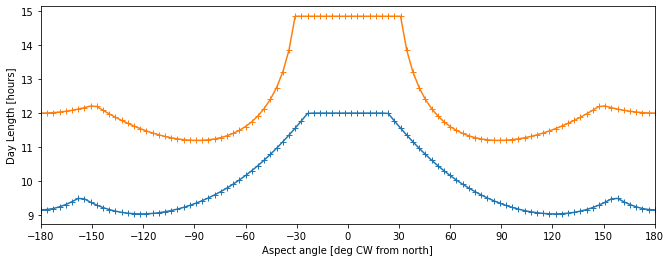

In [13]:
lat1_deg = 0.0    # Equator
lat2_deg = 40.0   # Boulder
# lat2_deg = 67.0

# Try changing the Julian day
Julian_day = June_Solstice_Julian_Day_2023()
# Julian_day = December_Solstice_Julian_Day_2023()
# Julian_day = March_Equinox_Julian_Day_2023()
# Julian_day = September_Equinox_Julian_Day_2023()

# beta  = 20.0 * (np.pi / 180.0)
beta  = 40.0 * (np.pi / 180.0)  # makes day length = zero sometimes!

alpha_rad = (np.arange(100)/99) * (2 * np.pi)  # [0, 2Pi]
alpha_rad = alpha_rad - np.pi
alpha_deg = alpha_rad * (180 / np.pi)

x  = alpha_deg
y1 = solar.Day_Length_Slope( lat1_deg, Julian_day, alpha_rad, beta )
y2 = solar.Day_Length_Slope( lat2_deg, Julian_day, alpha_rad, beta )
xticks = 30 * (np.arange(13) - 6)

print('y1_min, y1_max =', y1.min(), ', ', y1.max())
print('y2_min, y2_max =', y2.min(), ', ', y2.max())

tfvis.plot_data( x, y1, y2=y2, xmin=x.min(), xmax=x.max(),
                 x_name='Aspect angle', x_units='deg CW from north',
                 y_name='Day Length', y_units='hours',
                 marker='+', x_size=11, y_size=4, xticks=xticks)

## Appendix 1: Installing TopoFlow in a conda Environment  <a id="setup"></a>

To run this Jupyter notebook, it is recommended to use Python 3.7 from an Anaconda distribution and to install the required Python packages in a conda environment called <b>tf36</b>.  This prevents conflicts with other Python packages you may have installed.
The Anaconda distribution includes many packages from the
[<b>Python Standard Library</b>](https://docs.python.org/3/library/).

First, download the TopoFlow 3.6 package from GitHub repo "topoflow36" at:
<b>https://github.com/peckhams/topoflow36</b>.
Copy or unzip the package into some directory on your computer.  Let's refer to this full path as TF36_DIR.  e.g. TF36_DIR = /Users/peckhams/Dropbox/TopoFlow_3.6

Installing TopoFlow 3.6 with pip causes most of its dependencies to be installed automatically.  However, if you want to run the growing collection of Jupyter notebooks (such as this one) that highlight TopoFlow functionality, you will also need to install the
[<b>nb_conda</b>](https://docs.anaconda.com/anaconda/user-guide/tasks/use-jupyter-notebook-extensions/) package, and optionally the <b>jupyterlab</b> package (see below).
In addition, some of the new TopoFlow utilities (e.g. regrid.py and visualize.py) require the
[<b>gdal</b>](https://pypi.org/project/GDAL/) and
[<b>matplotlib</b>](https://matplotlib.org/) packages.
Simply type the following commands at an OS prompt after installing Anaconda and downloading TopoFlow.

``` bash
% conda update -n base conda
% conda create --name tf36
% conda activate tf36
% conda list
% conda install nb_conda
% conda install gdal
% conda install matplotlib
% cd TF36_DIR
% pip install -e .   (-e is the editable/developer option)
```

<b>Note:</b>  The <b>pip</b> package manager is used to install TopoFlow 3.6, since it is not available as a conda package.  (It gets installed when you install <b>nb_conda</b>.) However, like conda, pip will install a package and its dependencies into the currently active conda environment, as explained
[<b>in these docs</b>](https://docs.conda.io/projects/conda/en/4.6.1/user-guide/tasks/manage-pkgs.html#installing-non-conda-packages).  If you switch to another environment with <b>conda activate envname</b>, you can confirm that topoflow (or cfunits, gdal, netcdf4, etc.) is not there with <b>conda list</b>. 

<b>Note:</b>  Some of the new TopoFlow utilities use a Python package version of [<b>GDAL</b>](https://pypi.org/project/GDAL/).  At the time of this writing, installing <b>gdal</b> from the <b>conda-forge </b> with <i>conda install -c conda-forge gdal</i> did not work.

<b>Note:</b> The netCDF4 package will be installed as a TopoFlow dependency.

#### <b>Conda Environments</b>

Note that <b>conda</b> is the name of the package manager for the popular Anaconda Python distribution.  One feature of conda is support for multiple environments, which are isolated from one another.  When you install Anaconda, an environment called <b>base</b> is created for you and a base set of commonly-used Python packages are installed there.  However, you can (and should!) create additional, named environments and install different sets of Python packages into them without worrying about potential conflicts with packages in other environments.  Type <b>conda env list</b> to list your available environments.  You can switch to one of your other environments using the command <b>conda activate envname</b>.  (Replace "envname" with the name of an environment.) You can switch back to the base environment with the command <b>conda deactivate</b>.  It is better not to install new packages into the base environment.  See the online conda documentation on [<b>Managing Environments</b>](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html) for more information.

It is always a good idea to update conda itself before creating new environments and installing packages in them. The "-n" flag is followed by the name of the environment to update, and the "-c" flag is followed by the name of the <b>channel</b> from which to get packages.  A channel is a collection of Python packages that are provided and maintained by some group.  The word "defaults" refers to
[<b>Anaconda's own collection</b>](https://docs.anaconda.com/anaconda/packages/pkg-docs/), while
[<b>conda-forge</b>](https://conda-forge.org/feedstocks/)
refers to another popular collection and the GitHub organization that maintains it.  Many Python packages are available from both of these channels.  (However, the ipyleaflet and pydap  packages are currently not available in the Anaconda collection.) When you are installing several packages into an environment, the potential for installation problems seems to be less if you get them all from the same channel.  Keep in mind that packages you install will likely depend on many other Python packages, so there is a potential for conflicts, usually related to different package versions.  Using conda environments helps to mitigate against this and helps with <b>reproducibility</b>.

Once you've switched to an environment with <b>conda activate envname</b>, you can type <b>conda list</b> to see a list of packages.  If you do this right after you create a new environment you will see that it contains no packages.  If you do this right after installing each package above you will see that:

<ul>
    <li>Installing <b>nb_conda</b> triggers installation of <b>nb_conda_kernels</b>,
    <b>ipykernel</b> (5.3.0), <b>notebook</b> (6.0.3) and <b>traitlets</b>
    (4.3.3), among many others. 
    <li>Installing <b>gdal</b> triggers installation of #######.
    <li>Installing <b>matplotlib</b> triggers installation of ##########. 
</ul>

#### <b>Jupyter Notebook Extensions</b>

Note that <b>nb_conda</b> is installed first above, and triggers installation of <b>nb_conda_kernels</b> along with <b>notebook</b>.  This is important as it makes your Jupyter notebook app aware of your conda environments and available in the app as "kernels".  Anaconda provides a helpful page on the
[<b>Jupyter Notebook Extensions</b>](https://docs.continuum.io/anaconda/user-guide/tasks/use-jupyter-notebook-extensions/).
That page also explains how you can enable or disable these extensions individually. The command <b>jupyter nbextension list</b> shows you the extensions that are installed and whether they are enabled.  If you run the <b>jupyter notebook</b> or <b>jupyter lab</b> command in an environment that has <b>nb_conda_kernels</b> installed (see below), you will have the ability to associate one of your available conda environments with any new notebook you create.  Different environments give rise to different <b>kernels</b> in Jupyter, and the kernel name includes the environment name, e.g. <b>Python \[conda env:balto\]</b>.  The kernel name is displayed in the upper right corner.  Notebooks typically open with the "environment kernel" they were created with. However, there is a <b>Change Kernel</b> option in the <b>Kernel</b> menu in the Jupyter app menu bar. (After changing the kernel, you may need to choose <b>Restart</b> from the <b>Kernel</b> menu.

#### <b>Cloning a conda Environment</b>

If your notebook is working but then you want to import additional packages (possibly with many dependencies, and potential for problems), you can keep the first environment but clone it with
<b><i>conda create --name clonename --copy --clone envname</i></b>,
and then install the additional packages in the clone.  This way, you can switch to the new environment's kernel and try to run your notebook, but if you run into any problems you can easily revert back to the original environment and functionality.

<b>Note:</b> Setting the "--copy" flag installs all packages using copies instead of hard or soft links.  This is necessary to avoid problems when using <b>pip</b> together with <b>conda</b> as described [<b>on this page</b>](https://stackoverflow.com/questions/43879119/installing-tensorflow-in-cloned-conda-environment-breaks-conda-environment-it-wa).

#### <b>Running Notebooks in the Jupyter Notebook App</b>

When you want to run the notebook, type <b>conda activate tf36</b> (at an OS command prompt) to activate this environment.  Then change to the directory that contains this notebook and type <b>jupyter notebook</b>.  By default, this folder is called <b>Jupyter</b> and is in your home directory.  In the app, choose this notebook by name, "TopoFlow_Getting_Started.ipynb", and make sure to choose the kernel called:  <b>Python \[conda env:balto\]</b>.  See the References section at the end for more info.

#### <b>Running Notebooks in the JupyterLab App</b>

The
[<b>JupyterLab</b>](https://jupyterlab.readthedocs.io/en/stable/index.html)
app is a cool, new successor to the Notebook app and offers many additional features.  If you want to use this notebook in JupyterLab, you need to install one more Python package, as follows.

``` bash
% conda activate tf36
% conda install -c conda-forge jupyterlab
```

You launch the JupyterLab app by typing <b>jupyter lab</b> instead of <b>jupyter notebook</b>.  To quit, choose <b>Logout</b> or <b>Shutdown</b> from the app's <b>File</b> menu.
